<a href="https://colab.research.google.com/github/CocoTheAussieCat/dl_at3/blob/master/Final_Model_for_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - AT3 - Final Model
Team name: **AROCworkOrange**

Please run final cell for validation of results. 

# Sources
This notebook is based on code from Akshat Maheshwari's *Image Captioning using Keras (in Python)*, n.d.,  <https://iq.opengenus.org/image-captioning-using-keras/> and the associated GitHub repository *Image-Captioning-Using-Keras*, <https://github.com/akki3d76/Image-Captioning-Using-Keras>.

The code for data pre-processing, model architecture and evaluation with BLEU scores has been adapted from Maheshwari's original work. 

The data generator code has been adapted from Jeff Heaton's original work in the GitHub repository *T81-588 Applications of Deep Neural Networks*, <https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb>. 

# Mount Google Drive -- RUN
All data is located in `Experimentation` folder of Google Drive. 

In [0]:
# Use most recent version of tensorflow
%tensorflow_version 2.x

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Set directory
This should be the base directory containing all the Flickr8k files

In [5]:
# Direct the workbook into the project folder
%cd drive/Shared\ drives/DL_AT3/ImageCaptioning

/content/drive/Shared drives/DL_AT3/ImageCaptioning


In [0]:
import os 
dataset_dir = os.getcwd() 

In [7]:
# Check the directory
dataset_dir

'/content/drive/Shared drives/DL_AT3/ImageCaptioning'

In [8]:
# Check working director set correctly
!pwd

/content/drive/Shared drives/DL_AT3/ImageCaptioning


In [9]:
# Check the files inside the directory
!ls

captions.txt		    Flickr8k.token.txt
checkpoints		    Flickr_8k.trainImages.txt
CrowdFlowerAnnotations.txt  glove.6B.200d.txt
ExpertAnnotations.txt	    Group_model.ipynb
Flicker8k_Dataset	    __MACOSX
Flickr8k_Dataset.zip	    readme.txt
Flickr_8k.devImages.txt     test_features_inception.pkl
Flickr8k.lemma.token.txt    train_features_inception.pkl
Flickr_8k.testImages.txt    val_features_inception.pkl
Flickr8k_text.zip


## Unzip files
Only required once, if files are already lists in the directory unzipping is not required again.

In [0]:
#Unzip the Image Dataset
#!unzip Flickr8k_Dataset.zip

In [0]:
#Unzip the Text Dataset
#!unzip Flickr8k_text.zip

## Set directories

In [0]:
# Set the dataset directory and relative directories
image_dir = dataset_dir + '/Flicker8k_Dataset'
caption_dir = dataset_dir + '/Flickr8k.token.txt'
train_dir = dataset_dir + '/Flickr_8k.trainImages.txt'
test_dir = dataset_dir + '/Flickr_8k.testImages.txt'
val_dir = dataset_dir +'/Flickr_8k.devImages.txt'

# Setup -- RUN

Import libraries, set working directory and relative paths

## Import libraries

In [0]:
import pandas as pd
import numpy as np
from numpy import argmax
import array as arr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from pickle import dump, load
import string
import os
from time import time
import time
import random

from PIL import Image
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Embedding, Dropout, Add, TimeDistributed, RepeatVector, Activation, Reshape, concatenate,BatchNormalization

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
	
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

## Set seeds
For reproducible results

In [0]:
# Set seeds for numpy and tensorflow
tf.random.set_seed(12)
np.random.seed(12)

## Train, validation and test file names
Create lists of dataset file names.

In [0]:
# Gets all files in directory and extracts filename without extension
# Returns a list
def img_id(filename):
    """
    Inputs      - filename = directory where files are located
    Outputs     - img_name = list of image filenames
    """
    with open(filename) as file:
        data = file.readlines()
        img_name = []
        for img_id in data:
            img_name.append(img_id.split('.')[0])
    return img_name    

In [15]:
# Create lists of filenames for train, val and test
train_img_name = img_id(train_dir) 
val_img_name = img_id(val_dir) 
test_img_name = img_id(test_dir) 

# Print 5 sample image names to check function worked correctly
print('Samples from train:')
print(*train_img_name[:5],sep='\n') 

# Check length of datasets
print('\nNumber of images in train data:',len(train_img_name)) 
print('\nNumber of images in val data:',len(val_img_name))
print('\nNumber of images in test data:',len(test_img_name))

Samples from train:
2513260012_03d33305cf
2903617548_d3e38d7f88
3338291921_fe7ae0c8f8
488416045_1c6d903fe0
2644326817_8f45080b87

Number of images in train data: 6000

Number of images in val data: 1000

Number of images in test data: 1000


# Caption pre-processing -- DO NOT RUN
Process caption text for input into image captioning model. 

Source: <https://github.com/akki3d76/Image-Captioning-Using-Keras/blob/master/Captionate.ipynb>

Each image has 5 captions (#0 to #4).
* 5 captions turned into a list with associated image id. 

* Captions then cleaned to remove punctuation. 

* Output is saved as `caption.txt` so this code DOES NOT need to be run again. The file can simply be reloaded. 

## Load captions from original .txt file

In [0]:
def load_doc(filename):
  """
  Inputs      - filename = directory where captions are located
  Outputs     - text = file read line by line
  """
    with open(filename) as file:
        text = file.readlines()
        return text

In [0]:
# Read in caption text file
text = load_doc(caption_dir)

# Check file has been read in correctly by looking at 10 lines
for line in text[:10]:
    print(line,end='')

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


## Map images file names to captions
Create a dictionary of captions with corresponding image file name (with .jpg extension removed)

In [0]:
def image_to_captions(text):
    """
    Inputs      - text = output from load_doc()
    Outputs     - hash_map = dictionary with image id as key, captions as values
    """
    hash_map = {}
    for line in text:
        token = line.split()
        image_id = token[0].split('.')[0] # separating with '.' to extract image id (removing .jpg)
        image_caption = ' '.join(token[1: ])
        
        if(image_id not in hash_map):
            hash_map[image_id] = [image_caption]
        else:
            hash_map[image_id].append(image_caption)
        
    return hash_map

In [0]:
# Create dictionary of image ids and captions
map_img_to_captions = image_to_captions(text)

# Check by printing five captions for a sample image
print(*map_img_to_captions['1000268201_693b08cb0e'],sep='\n')

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


## Clean captions
Captions are already quite clean, with no accented characters, digits or special characters. However, punctuation needs to be stripped and all characters converted to lowercase.

In [0]:
# For each image, clean captions and put all five captions into single list
def preprocess(map_img_to_captions):
    """
    Inputs      - map_img_to_captions = output from image_to_captions()
    Outputs     - map_img_to_captions = with cleaned captions
    """
    preprocessed_captions = []
    for key in map_img_to_captions.keys():
        for idx in range(len(map_img_to_captions[key])):
            tokens = map_img_to_captions[key][idx].split()
            tokens = [token.lower() for token in tokens if len(token)>1 if token.isalpha()]
            map_img_to_captions[key][idx] = ' '.join(tokens)
            
    return map_img_to_captions

In [0]:
# Clean captions
preprocessed_map = preprocess(map_img_to_captions)

# Check by printing list of captions for sample image
preprocessed_map['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

## Create vocabulary from captions
Build a set with unique words from all the captions. Check by printing out the size of the vocab.

In [0]:
# Make a set of unique words in all the captions
def create_vocabulary(preprocessed_map):
    """
    Inputs      - preprocessed_map = output from preprocess()
    Outputs     - vocabulary = set with all unique words from captions
    """
    vocabulary = set()
    for img_captions in preprocessed_map.values(): # list of 5 captions for each image
        for caption in img_captions:
            for token in caption.split():
                vocabulary.add(token)    
    return vocabulary

In [0]:
# Create vocabulary set
vocabulary = create_vocabulary(preprocessed_map)

# Check vocab size
print('Vocabulary size:',len(vocabulary))

Vocabulary size 8357


## Save captions.txt
Save image id and clean captions as `captions.txt` in working directory.



In [0]:
# Create list of image ids and preprocessed captions
# Write to txt file
def save_captions(preprocessed_map, filename):
    """
    Inputs      - preprocessed_map = output from preprocess()
                - filename = string with .txt extension
    Outputs     - none, file written to working directory
    """ 
    data = []
    for image_id,image_captions in preprocessed_map.items():
        for caption in image_captions:
            data.append(image_id + ' ' + caption + '\n')
            
    with open(filename,'w') as file:
        for line in data:
            file.write(line)

In [0]:
# Save captions to file in working directory
save_captions(preprocessed_map,'captions.txt')

# Image pre-processing -- DO NOT RUN
Images are pre-processed so they can be run through Inceptions-V3 to extract features. 

Feature vectors saved as:

* `features_train_inception.pkl`

* `features_val_inception.pkl`

* `features_test_inception.pkl`


## Pre-process images
Pre-process so images are in correct format to be fed into Inception-V3 model for feature extraction.



### Create lists of train and validation image file names,including .jpg extension

In [0]:
def images_name(path):
    """
    Inputs      - path = directory
    Outputs     - img_name = set of unique image names
    """
    img_name = set([path+image for image in os.listdir(path)])
    return img_name

In [0]:
# Create list of image filename with .jpg extension
all_images_filnames = images_name(image_dir)
train_img_filenames = [image_dir + '/' + img + '.jpg' for img in train_img_name]
val_img_filenames = [image_dir + '/' + img + '.jpg' for img in val_img_name]
test_img_filenames = [image_dir + '/' + img + '.jpg' for img in test_img_name]

### Pre-process images as required for Inception-V3

In [0]:
# Loads image, adds 4th dimension for colour channel, pre-process for Inception-V3
# Returns array with dims (1, 299, 299, 3)

def preprocess_image(img_path):
    """
    Inputs      - img_path = directory
    Outputs     - img = pre-processed image of shape (1, 299, 299, 3)
    """    
    img = image.load_img(img_path,target_size=(299,299)) 

    # Converts PIL image to numpy array (299,299,3)
    img = image.img_to_array(img) 

    # Add one more dimension: (1, 299, 299, 3)
    img = np.expand_dims(img, axis=0) 

    # Pre-process image for input into Inception-V3 model
    img = preprocess_input(img) 

    return img

In [0]:
# Check preprocess_image works by running one sample image through it

sample_image = image_dir +'/1000268201_693b08cb0e.jpg'
img = preprocess_image(sample_image)
plt.imshow(img[0])

## Load Inception-V3 model
Load model and remove last layer so that features can be extracted from images.

In [0]:
# Load Inception-V3 model
model = InceptionV3(weights='imagenet')

# Create new model, by removing last layer (output layer) from Inception-V3
model_new = Model(inputs=model.input, outputs=model.layers[-2].output) # outputs=(second last layer output)

96116736/96112376 [==============================] - 1s 0us/step


## Extract feature from images
Run images through Inception-V3 model to extract features as a vector. 

Each image will have dimensions of (2048, ), which is the required size for inputting into image captioning model.

In [0]:
# Function to extract features from image into a vector of size (2048, )
def extract_image_features(image):
    """
    Inputs      - image = image filename
    Outputs     - feature_vector = output vector from Inception-V3
    """
    # Pre-process image so it can be run through Inception-V3
    image = preprocess_image(image)
    
    # Extract features from image by running it through Inception-V3
    feature_vector = model_new.predict(image) 

    # Reshape from (1, 2048) to (2048, )
    feature_vector = feature_vector.reshape(feature_vector.shape[1], ) 

    return feature_vector

In [0]:
# Extract features from train images
start_train = time()
train_features = {}
for idx,img in enumerate(train_img_filenames):
    if( (idx+1)%500 == 0):
        print('Train images encoded ',idx+1)
    train_features[img] = extract_image_features(img)
print("Train image feature extraction took: {} seconds".format(time()-start_train))

Train images encoded  500
Train images encoded  1000
Train images encoded  1500
Train images encoded  2000
Train images encoded  2500
Train images encoded  3000
Train images encoded  3500
Train images encoded  4000
Train images encoded  4500
Train images encoded  5000
Train images encoded  5500
Train images encoded  6000
Train image feature extraction took: 3345.310848712921 seconds


In [0]:
# Extract features from validation images
start_val = time()
val_features = {}
for idx,img in enumerate(val_img_filenames):
    if( (idx+1)%500 == 0):
        print('Validation images encoded ',idx+1)
    val_features[img] = extract_image_features(img)
print("Validation image feature extraction took: {} seconds".format(time()-start_val))

Validation images encoded  500
Validation images encoded  1000
Validation image feature extraction took: 568.206071138382 seconds


In [0]:
# Extract features from test images
test_features = {}
for idx,img in enumerate(test_img_filenames):
    if( (idx+1)%500 == 0):
        print('Test images encoded ',idx+1)
    test_features[img] = extract_image_features(img)
print("Test image feature extracted")

## Save feature vectors to pickle files

In [0]:
# Save train, val and test features as pickle file in working directory
dump(train_features, open('train_features_inception.pkl', 'wb'))
dump(val_features, open('val_features_inception.pkl', 'wb'))
dump(test_features, open('test_features_inception.pkl', 'wb'))

# Load image features and captions -- RUN
Load image features from pickle files and get associated captions from caption dictionary

## Load pre-processed captions
Adds startseq, endseq to all captions

In [0]:
# Load and read pre-processed captions text file
def load_doc(filename):
    """
    Inputs      - filename = .txt file with pre-processed captions
    Outputs      - text = opened file
    """
    with open(filename) as file:
        text = file.readlines()
        return text

In [0]:
# Create dictionary with image id as key, captions as value
# Add 'startseq' and 'endseq' to caption
def load_captions(filename, filelist):
    """
    Inputs      - filename = .txt file with pre-prcocessed captions
                - filelist = list of images names for train/val/test
    Outputs     - captions = dictionary with image id as key, pre-processed captions as values
    """

    # Read in file
    doc = load_doc(filename) 
    captions = {}    
    
    # Create dictionary with image id as key, captions as values
    # Add startseq endseq to caption
    for line in doc:
        tokens = line.split()
        image_id, image_caption = tokens[0], tokens[1:]

        if(image_id in filelist):
            if(image_id not in captions):
                captions[image_id] = []
            
            modified_caption = 'startseq ' + ' '.join(image_caption) + ' endseq'
            captions[image_id].append(modified_caption)
    
    return captions

In [18]:
# Create train captions dictionary
train_captions = load_captions('captions.txt', train_img_name)

# Print a sample caption as a check
# Should return 5 captions, each sandwiched between 'startseq' 'endseq'
print(*train_captions['1000268201_693b08cb0e'],sep='\n')

startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


In [19]:
# Create val captions dictionary
val_captions = load_captions('captions.txt', val_img_name)

# Print a sample caption as a check
# Should return 5 captions, each sandwiched between 'startseq' 'endseq'
print(*val_captions['2391812384_7429b5e567'],sep='\n')

startseq child dressed in purple clothing and hat runs in splashing water while man and small boy walk nearby endseq
startseq child wearing purple runs through splashing water while man in red looks on endseq
startseq family playing the spray of fountain endseq
startseq man and two toddlers get sprinkled as they pass an ornamental fountain endseq
startseq young girl wearing purple running through water endseq


In [20]:
# Create test captions dictionary
test_captions = load_captions('captions.txt', test_img_name)

# Print a sample caption as a check
# Should return 5 captions, each sandwiched between 'startseq' 'endseq'
print(*test_captions['3385593926_d3e9c21170'],sep='\n')

startseq the dogs are in the snow in front of fence endseq
startseq the dogs play on the snow endseq
startseq two brown dogs playfully fight in the snow endseq
startseq two brown dogs wrestle in the snow endseq
startseq two dogs playing in the snow endseq


## Load pre-processed features

In [21]:
# Load train pickle file
train_features = load(open('train_features_inception.pkl', "rb"))

# Create a list of all training captions
all_train_captions = []
for captions in train_captions.values():
    for caption in captions:
        all_train_captions.append(caption)

# Check length of captions is correct
assert len(all_train_captions) == 5 * len(train_img_name)

# Check by printing 10 captions
print(*all_train_captions[:10],sep='\n')

startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
startseq black dog and spotted dog are fighting endseq
startseq black dog and dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


In [22]:
# Load val pickle file
val_features = load(open('val_features_inception.pkl', "rb"))

# Create a list of all validation captions
all_val_captions = []
for captions in val_captions.values():
    for caption in captions:
        all_val_captions.append(caption)

# Check length of captions is correct  
assert len(all_val_captions) == 5 * len(val_img_name)

# Check by printing 10 captions
print(*all_val_captions[:10],sep='\n')

startseq child and woman are at waters edge in big city endseq
startseq large lake with lone duck swimming in it with several people around the edge of it endseq
startseq little boy at lake watching duck endseq
startseq young boy waves his hand at the duck in the water surrounded by green park endseq
startseq two people are at the edge of lake facing the water and the city skyline endseq
startseq boy with stick kneeling in front of goalie net endseq
startseq child in red jacket playing street hockey guarding goal endseq
startseq young kid playing the goalie in hockey rink endseq
startseq young male kneeling in front of hockey goal with hockey stick in his right hand endseq
startseq hockey goalie boy in red jacket crouches by goal with stick endseq


In [23]:
# Load test pickle file
test_features = load(open('test_features_inception.pkl', "rb"))

# Create a list of all test captions
all_test_captions = []
for captions in test_captions.values():
    for caption in captions:
        all_test_captions.append(caption)

# Check length of captions is correct  
assert len(all_test_captions) == 5 * len(test_img_name)

# Check by printing 10 captions
print(*all_test_captions[:10],sep='\n')

startseq blond woman in blue shirt appears to wait for ride endseq
startseq blond woman is on the street hailing taxi endseq
startseq woman is signaling is to traffic as seen from behind endseq
startseq woman with blonde hair wearing blue tube top is waving on the side of the street endseq
startseq the woman in the blue dress is holding out her arm at oncoming traffic endseq
startseq boy in his blue swim shorts at the beach endseq
startseq boy smiles for the camera at beach endseq
startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq
startseq children playing on the beach endseq
startseq the boy is playing on the shore of an ocean endseq


#  Create vocab -- RUN
Select threshold for number of times a word must appear in training captions for word to be added to vocab.

Tokenize captions.


In [24]:
# Set threshold for number of times word must appear in captions to be included in vocab
corpus_threshold = 5

# Create corpus by tokenizing all training captions
corpus = []
for caption in all_train_captions:
    for token in caption.split():
        corpus.append(token)
        
hash_map = Counter(corpus)

# Create vocab by only including words from corpus that appears enough times in captions
vocab = []
for token,count in hash_map.items():
    if(count>=corpus_threshold):
        vocab.append(token)
        
print('Number of original tokens:', len(hash_map))
print('Number of tokens after threshold:', len(vocab))

Number of original tokens: 7265
Number of tokens after threshold: 2503


## Create word-to-index and index-to-word dictionaries

In [0]:
word_to_index = {}
index_to_word = {}
    
for idx,token in enumerate(vocab):
    word_to_index[token] = idx+1
    index_to_word[idx+1] = token

vocab_size = len(index_to_word) + 1 # Add for appended zeros

# Check lengths are identical
assert (len(index_to_word)) == (len(index_to_word))

## Find max length caption
Need to know max length caption to set padding size

In [0]:
def max_len_caption(all_train_captions):
    """
    Inputs      - all_train_captions = list of all train captions
    Outputs     - max_len = integer
    """
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption:',max_len)
    return max_len

In [28]:
# Determine maximum caption length
max_length_caption = max_len_caption(all_train_captions)

Maximum length of caption: 33


# Data generator

Code has been adapted from Jeff Heaton's GitHub repository *T81-588 Applications of Deep Neural Networks*, <https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb>

In [0]:
# Create data generator with required input for image captioning model
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
    """
    Inputs      - descriptions = captions dictionary
                - photos = features vector
                - wordtoix = word to index dictionary
                - max_length = maximum length of caption, outut from max_len_caption()
                - num_photos_per_batch = integer
    Outputs     - X1 = numpy array of image features
                - X2 = numpy array of caption sequences
                - y = numpy array of next word in caption
    """
    X1, X2, y = [], [], []
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            temp = '/content/drive/Shared drives/DL_AT3/Experimentation/Flicker8k_Dataset/'
            photo = photos[temp + key +'.jpg']
            for desc in desc_list:
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = [], [], []
                n=0

## Load GloVe vectors
Source: <https://nlp.stanford.edu/projects/glove/>

Used to create the embedding matrix for caption input encoder. 

Will match words that are similar, for example frog and toad.

glove.6B.200d.txt must be located in working directory.


In [30]:
# Load GloVe file
embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


In [0]:
# Create embedding matrix
embedding_dim = 200

# Create 200 dim dense vector for each of the words in vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

# Check shape size        
assert embedding_matrix.shape == (vocab_size, embedding_dim)

# Image caption model -- RUN
Based on merge-model described by Tanti et al. in *Where to put the Image in an Image Caption Generator*

source: <https://arxiv.org/abs/1703.09137>

## Define model

In [32]:
# Feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence model
inputs2 = Input(shape=(max_length_caption,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Entire model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 200)      500800      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

## Set final layers weights to equal embedding matrix


In [0]:
# Use GloVe embedding matric as weights for second layer of caption encoder
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

## Compile model

In [0]:
# Compile model using adam and categorical cross entropy loss
# Change learning rate as necessary
learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate = learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# Train model -- RUN
Use checkpoing callbacks to save training information.

Change batch size as required.

Epochs are set in `model.fit()`, change as required.

In [0]:
# Set number of pictures per batch 
number_pics_per_batch = 32

In [0]:
# Create data generators
train_generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_batch)
val_generator = data_generator(val_captions, val_features, word_to_index, max_length_caption, number_pics_per_batch)

## Set callbacks
Make sure you set `check_path` correctly!


In [0]:
# Set callbacks
#### MAKE A DIRECTORY TO SAVE CHECKPOINTS TO ##############################
# eg: check_path = 'checkpoints/rebecca/exp_2'
###########################################################################

check_path = 'checkpoints/rebecca/final' # CHANGE THIS
!mkdir -p $check_path

check_dir = check_path+'/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

# Monitor validation loss
checkpoint = ModelCheckpoint(check_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Use early stopping, change patience as required
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Use reduce LR, change patience and factor as required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

## Train model

In [38]:
# Fit model
tic = time.perf_counter()

# Change epochs as necessary
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_img_name) // number_pics_per_batch,
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_img_name) // number_pics_per_batch ,
    callbacks = [checkpoint, early_stopping, reduce_lr])

toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model ran in: {run_time:0.2f} minutes')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
187/187 [==============================] - ETA: 0s - loss: 4.9685
Epoch 00001: val_loss improved from inf to 4.19862, saving model to checkpoints/rebecca/final/model-ep001-loss4.968-val_loss4.199.h5
187/187 [==============================] - 39s 209ms/step - loss: 4.9685 - val_loss: 4.1986 - lr: 0.0010
Epoch 2/100
187/187 [==============================] - ETA: 0s - loss: 3.9861
Epoch 00002: val_loss improved from 4.19862 to 3.77645, saving model to checkpoints/rebecca/final/model-ep002-loss3.986-val_loss3.776.h5
187/187 [==============================] - 39s 211ms/step - loss: 3.9861 - val_loss: 3.7765 - lr: 0.0010
Epoch 3/100
187/187 [==============================] - ETA: 0s - loss: 3.6445
Epoch 00003: val_loss improved from 3.77645 to 3.58548, saving model to checkpoints/rebecca/final/model-ep003-loss3.645-val_loss3.585.h5
187/187 [==============================] - 39s 209ms/step - loss: 3.6445 

# Evaluate image caption model -- RUN
Plot loss curves.

Calculate BLEU scores for validation and test set (if appropriate).

## Loss curves


In [0]:
def modelPlot(history_name, plt_title):
    """
    Generates plot (with title) for model training and validation accuracy and loss by epoch
    Inputs  - history_name = history object resulting from fitted model
            - plt_title = title for plot, as string
    Output  - plot
    """
    from matplotlib.pyplot import savefig
    loss_filename = check_path+'/loss.png'

    plt.plot(history_name.history['loss'], label='Training', color = 'blue')
    plt.plot(history_name.history['val_loss'], label='Validation', color = 'orange')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title(plt_title)
    plt.legend()
    plt.savefig(loss_filename)
    plt.show()
    plt.close()

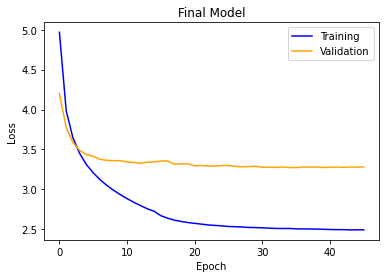

In [40]:
# Change title
title = 'Final Model' # CHANGE THIS

# Plot will save to check_path as loss.png
modelPlot(history, title)

## BLEU scores
Generate BLEU-1 through BLEU-4 scores

## Load best model

In [0]:
# Find best model file name from model.fit output and insert below
best_model = 'checkpoints/rebecca/final/model-ep036-loss2.504-val_loss3.272.h5' # CHANGE THIS

# Load best model
best_model = tf.keras.models.load_model(best_model)

In [0]:
# Predict a caption for a word using model
def predict_caption(model, photo, wordtoix, ixtoword, max_length):
    """
    Inputs      - model = Tensorflow model object after training
                - photo = image features vector
                - wordtoix = word to index dictionary
                - ixtoword = index to word dictionary
                - max_length = max length of caption
    Outputs     - final = predicted caption for image as string
    """
    # Reshape feature vector for input into trained model
    photo = photo.reshape((1,2048))

    # Start prediction caption with startseq
    in_text = 'startseq'

    # Predict caption using trained model
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    # Break caption into strings
    final = in_text.split()

    # Remove startseq
    final = final[1:-1]

    # Join caption into single string
    final = ' '.join(final)
    return final

In [0]:
# Evaluate model by predicting captions for images
# Compare predicted captions to truth captions
# Calculate BLEU-1 through BLEU-4 to determine model fit
def evaluate_model(model, captions, features, wordix, ixword, max_length, dataset = 'val'):
	"""
	Inputs			- model = Tensorflow model object after training
							- captions = pre-processed caption dictionary
							- features = image feature vectors
              - wordtoix = word to index dictionary
              - ixtoword = index to word dictionary
              - max_length = max length of caption	
							- dataset = string, either 'val' or 'test'						
	Outputs			- none, prints results to screen
	"""
	actual, predicted = list(), list()
	# Step over the whole set
	for key, desc_list in captions.items():
		
		# Generate description (fix because feature files were generated in different folders)
		if dataset == 'test':
			temp = '/content/drive/Shared drives/DL_AT3/ImageCaptioning/Flicker8k_Dataset/'
		else:
			temp = '/content/drive/Shared drives/DL_AT3/Experimentation/Flicker8k_Dataset/'
		photo = features[temp + key + '.jpg']
		yhat = predict_caption(model, photo, wordix, ixword, max_length)
		
		# Store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	
	# Calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

### Validation dataset

In [44]:
# Calculate BLEU scores on validation dataset for best model
tic = time.perf_counter()
print('Validation set:')
evaluate_model(best_model, val_captions, val_features, word_to_index, index_to_word, max_length_caption)
toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model evaluated in: {run_time:0.2f} minutes')

Validation set:
BLEU-1: 0.467540
BLEU-2: 0.286222
BLEU-3: 0.202820
BLEU-4: 0.098692
Model evaluated in: 5.12 minutes


### Test dataset
Only run this for **THE BEST** models.

In [45]:
# Calculate BLEU scores on test dataset for best model
tic = time.perf_counter()
print('Test set:')
evaluate_model(best_model, test_captions, test_features, word_to_index, index_to_word, max_length_caption, 'test')
toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model evaluated in: {run_time:0.2f} minutes')

Test set:
BLEU-1: 0.458873
BLEU-2: 0.287829
BLEU-3: 0.211063
BLEU-4: 0.110995
Model evaluated in: 4.85 minutes


# Save files for submission


In [0]:
# Dictionary of data required for evaluation
final_model_data = {}
final_model_data['val_captions'] = val_captions
final_model_data['val_features'] = val_features
final_model_data['test_captions'] = test_captions
final_model_data['test_features'] = test_features
final_model_data['word_to_index'] = word_to_index
final_model_data['index_to_word'] = index_to_word
final_model_data['max_length_caption'] = max_length_caption

# Save to pickle file for submission
dump(final_model_data, open('final_model_data.pkl', 'wb'))

# SUBMISSION: FINAL MODEL AND RESULTS

Run cell to print out BLEU scores for validation and testing dataset

Requires `final_model_data.pkl` and `final_model.h5` to be located in working directory

May take 10-15 minutes to run. Output of BLEU scores for validation set and for testing set will be printed to screen.

In [49]:
import pandas as pd
import numpy as np
from numpy import argmax
import array as arr
import pickle
from pickle import load
import os

import tensorflow as tf

from tensorflow.keras.models import Model
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Set seeds for numpy and tensorflow
tf.random.set_seed(12)
np.random.seed(12)

# Predict a caption for a word using model
def predict_caption(model, photo, wordtoix, ixtoword, max_length):
    """
    Inputs      - model = Tensorflow model object after training
                - photo = image features vector
                - wordtoix = word to index dictionary
                - ixtoword = index to word dictionary
                - max_length = max length of caption
    Outputs     - final = predicted caption for image as string
    """
    # Reshape feature vector for input into trained model
    photo = photo.reshape((1,2048))

    # Start prediction caption with startseq
    in_text = 'startseq'

    # Predict caption using trained model
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    # Break caption into strings
    final = in_text.split()

    # Remove startseq
    final = final[1:-1]

    # Join caption into single string
    final = ' '.join(final)
    return final

# Evaluate model by predicting captions for images
# Compare predicted captions to truth captions
# Calculate BLEU-1 through BLEU-4 to determine model fit
def evaluate_model(model, captions, features, wordix, ixword, max_length, dataset = 'val'):
	"""
	Inputs			- model = Tensorflow model object after training
							- captions = pre-processed caption dictionary
							- features = image feature vectors
              - wordtoix = word to index dictionary
              - ixtoword = index to word dictionary
              - max_length = max length of caption	
							- dataset = string, either 'val' or 'test'						
	Outputs			- none, prints results to screen
	"""
	actual, predicted = list(), list()
	# Step over the whole set
	for key, desc_list in captions.items():
		
		# Generate description (fix because feature files were generated in different folders)
		if dataset == 'test':
			temp = '/content/drive/Shared drives/DL_AT3/ImageCaptioning/Flicker8k_Dataset/'
		else:
			temp = '/content/drive/Shared drives/DL_AT3/Experimentation/Flicker8k_Dataset/'
		photo = features[temp + key + '.jpg']
		yhat = predict_caption(model, photo, wordix, ixword, max_length)
		
		# Store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	
	# Calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# Load final_model_data.pkl
data = pickle.load(open('final_model_data.pkl', 'rb'))

# Load final model
final_model = tf.keras.models.load_model('final_model.h5')

# Get validation BLEU scores
print('Validation set:')
evaluate_model(final_model, data['val_captions'], data['val_features'], \
               data['word_to_index'], data['index_to_word'], \
               data['max_length_caption'])
print('------------')

# Get test BLEU scores
print('test set:')
evaluate_model(final_model, data['test_captions'], data['test_features'], \
               data['word_to_index'], data['index_to_word'], \
               data['max_length_caption'] , dataset = 'test')

Validation set:
BLEU-1: 0.467540
BLEU-2: 0.286222
BLEU-3: 0.202820
BLEU-4: 0.098692
------------
test set:
BLEU-1: 0.458873
BLEU-2: 0.287829
BLEU-3: 0.211063
BLEU-4: 0.110995
